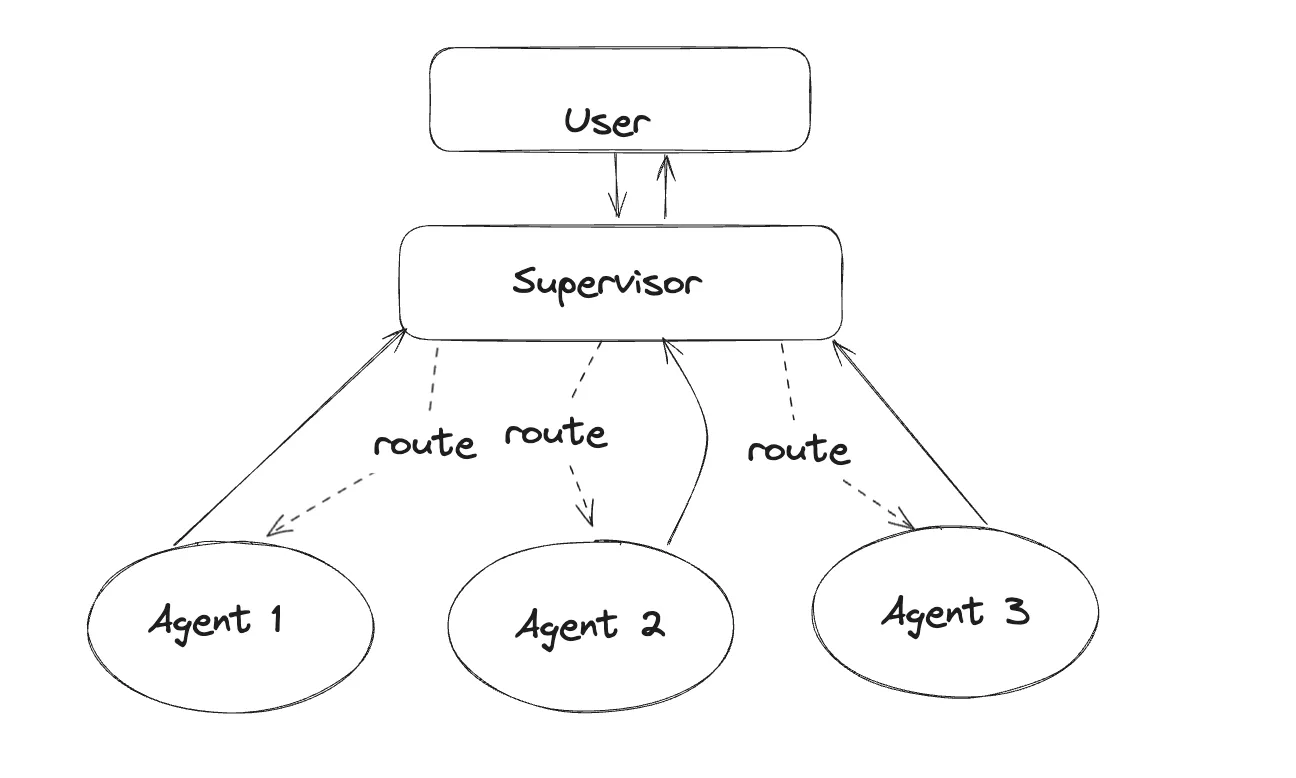

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [ ]:
'''from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")'''

In [62]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")

In [63]:
print(llm.invoke("Hello, how are you?").content)

I am doing well, thank you for asking.  How are you?



In [64]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_prompt),
#         MessagesPlaceholder(variable_name="messages"),
#         (
#             "system",
#             "Given the conversation above, who should act next?"
#             " Or should we FINISH? Select one of: {options}",
#         ),
#     ]
# ).partial(options=str(options), members=", ".join(members))

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt + "Given the conversation above, who should act next? Or should we FINISH? Select one of: {options}"),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(options=str(options), members=str(members))


# llm = ChatOpenAI(model="gpt-4o")
class routeResponse(BaseModel):
    next: Literal[*options]

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [35]:
str(options)

"['FINISH', 'Researcher', 'Coder']"

In [8]:
", ".join(["Researcher", "Coder"])

'Researcher, Coder'

In [65]:
import functools
import operator
from typing import Sequence, TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


from langchain_core.messages import HumanMessage
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


from langchain_community.tools.tavily_search import TavilySearchResults
tavily_tool = TavilySearchResults(max_results=5)
from langchain_experimental.tools.python.tool import PythonREPLTool
python_repl_tool = PythonREPLTool()  # This executes code locally, which can be unsafe


# Create the agents for the research and coding nodes
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Note: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

In [66]:
# Create the workflow graph
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")


graph = workflow.compile()

In [67]:
graph.invoke({"messages": ["What is 2+3?"]})

{'messages': ['What is 2+3?', HumanMessage(content='```\nprint(2 + 3)\n```', additional_kwargs={}, response_metadata={}, name='Coder', id='0138885b-41d7-4727-a579-97bad2cfd608'), HumanMessage(content='5\n', additional_kwargs={}, response_metadata={}, name='Coder')], 'next': 'FINISH'}

In [68]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```python\nprint("hello world")\n```', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```\nhello world\n```\n', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='OK.  Is there anything else?\n', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [70]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Create a code of a function that returns the sum of two numbers in python")
        ]
    }
):
    print(s)
    print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```python\ndef sum_two_numbers(a, b):\n  """\n  This function takes two numbers as input and returns their sum.\n\n  Args:\n    a: The first number.\n    b: The second number.\n\n  Returns:\n    The sum of a and b.\n  """\n  return a + b\n```\n', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```python\ndef sum_two_numbers(a, b):\n  """\n  This function takes two numbers as input and returns their sum.\n\n  Args:\n    a: The first number.\n    b: The second number.\n\n  Returns:\n    The sum of a and b.\n  """\n  return a + b\n```\nOK.  Is there anything else I can help with?\n', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='Yes,  what is 2 + 2?\n', additional_kwargs={}, response_metadata={}, name

In [71]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Create a code of a function that returns the sum of two numbers in python")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```python\ndef sum_two_numbers(a, b):\n  """\n  This function returns the sum of two numbers.\n\n  Args:\n    a: The first number.\n    b: The second number.\n\n  Returns:\n    The sum of a and b.\n  """\n  return a + b\n```\n', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```python\ndef sum_two_numbers(a, b):\n  """\n  This function returns the sum of two numbers.\n\n  Args:\n    a: The first number.\n    b: The second number.\n\n  Returns:\n    The sum of a and b.\n  """\n  return a + b\n```\nOK.  I\'ve created the function.  How can I help you use it?  For example, what numbers would you like to sum?\n', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='```\nprint(sum_two_numbers(5, 3))\n```\n', 

In [73]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Just END the conversation")
        ]
    }
):
    print(s)
    print("----")

{'supervisor': {'next': 'FINISH'}}
----


In [74]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Just END the conversation")
        ]
    }
):
        if "__end__" not in s:
            print(s)
            print("----")

{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")